In [25]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import nibabel as nib
import numpy as np
import os
from sklearn.model_selection import train_test_split
import cv2
import torch
import torch.nn.functional as F

import matplotlib
import matplotlib.pyplot as plt
from skimage.transform import rotate
from skimage.util import montage

### Dataset and DataLoader Classes

In this notebook, we are working with brain tumor MRI data. The data is organized into images and corresponding segmentation masks. To handle this data efficiently, we use custom `Dataset` and `DataLoader` classes provided by PyTorch.

#### BrainTumourDataset Class

The `BrainTumourDataset` class is a custom dataset class that inherits from `torch.utils.data.Dataset`. It is designed to load and preprocess the brain tumor MRI images and their corresponding segmentation masks.

- **Initialization (`__init__` method)**:
    - `data_path` and `seg_path`: Paths to the image and segmentation data directories.
    - `file_ids`: List of file identifiers for the dataset.
    - `img_dim`: Dimensions to which the images and masks will be resized.
    - `transform`: Optional transformations to be applied to the images and masks.

- **Length (`__len__` method)**:
    - Returns the number of samples in the dataset.

- **Get Item (`__getitem__` method)**:
    - Loads and preprocesses the image and mask for a given index.
    - Calls the `__data_generation` method to load and preprocess the data.

- **Data Generation (`__data_generation` method)**:
    - Loads the image and segmentation mask using `nibabel`.
    - Resizes the images and masks to the specified dimensions using `cv2.resize`.
    - Normalizes the image data and converts the masks to one-hot encoded tensors.

#### BrainTumourDataModule Class

The `BrainTumourDataModule` class is a PyTorch Lightning data module that handles the data loading and preprocessing for training, validation, and testing.

- **Initialization (`__init__` method)**:
    - Initializes paths, batch size, number of workers, image dimensions, and transformations.

- **Prepare Data (`prepare_data` method)**:
    - Scans the data directory to get a list of all data files.

- **Setup (`setup` method)**:
    - Splits the data into training, validation, and test sets.
    - Creates instances of `BrainTumourDataset` for each split.

- **Data Loaders**:
    - `train_dataloader`, `val_dataloader`, and `test_dataloader` methods return `DataLoader` instances for the training, validation, and test datasets, respectively.

These classes allow us to efficiently load, preprocess, and iterate over the brain tumor MRI data during model training and evaluation.

In [26]:
TRAINING_DATA_PATH = "../BrainTumourData/imagesTr/"
TRAINING_SEGMENTATION_PATH = "../BrainTumourData/labelsTr/"

IMG_SIZE = 128

In [27]:
class BrainTumourDataset(Dataset):
    def __init__(
        self,
        data_path,
        seg_path,
        file_ids,
        img_dim=(IMG_SIZE, IMG_SIZE),
        transform=None,
    ):
        self.data_path = data_path
        self.seg_path = seg_path
        self.file_ids = file_ids
        self.dim = img_dim
        self.transform = transform
        self.n_channels = 2

    def __len__(self):
        return len(self.file_ids)

    def __getitem__(self, idx):
        file_id = self.file_ids[idx]
        X, y = self.__data_generation(file_id)
        return X, y

    def __data_generation(self, file_id):
        data_path = os.path.join(self.data_path, file_id)
        seg_path = os.path.join(self.seg_path, file_id)

        data = nib.load(data_path).get_fdata()
        seg = nib.load(seg_path).get_fdata()

        num_slices = data.shape[2]

        X = np.zeros((num_slices, *self.dim, self.n_channels), dtype=np.float32)
        y = np.zeros((num_slices, *self.dim), dtype=np.float32)

        flair = data[:, :, :, 0]
        t1w = data[:, :, :, 1]

        for i in range(num_slices):
            X[i, :, :, 0] = cv2.resize(flair[:, :, i], self.dim)
            X[i, :, :, 1] = cv2.resize(t1w[:, :, i], self.dim)

            y[i] = cv2.resize(
                seg[:, :, i],
                self.dim,
                interpolation=cv2.INTER_NEAREST,
            )

        y_tensor = torch.from_numpy(y).long()  # Convert to tensor with long type
        Y = F.one_hot(y_tensor, num_classes=4).permute(0, 3, 1, 2).float()
        X = X / np.max(X)
        return X, Y


class BrainTumourDataModule(pl.LightningDataModule):
    def __init__(
        self,
        data_path=TRAINING_DATA_PATH,
        seg_path=TRAINING_SEGMENTATION_PATH,
        batch_size=1,
        num_workers=4,
        img_dim=(IMG_SIZE, IMG_SIZE),
        transform=None,
    ):
        super().__init__()
        self.data_path = data_path
        self.seg_path = seg_path
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.img_dim = img_dim
        self.transform = transform
        self.train_ids = self.val_ids = self.test_ids = None

    def prepare_data(self):
        self.training_datas = [
            f.name for f in os.scandir(self.data_path) if f.is_file()
        ]

    def setup(self, stage=None):
        train_test_ids, val_ids = train_test_split(self.training_datas, test_size=0.2)
        train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15)

        self.train_ids = train_ids
        self.val_ids = val_ids
        self.test_ids = test_ids

        # Create datasets for each split
        self.train_dataset = BrainTumourDataset(
            self.data_path,
            self.seg_path,
            self.train_ids,
            img_dim=self.img_dim,
            transform=self.transform,
        )
        self.val_dataset = BrainTumourDataset(
            self.data_path,
            self.seg_path,
            self.val_ids,
            img_dim=self.img_dim,
            transform=self.transform,
        )
        self.test_dataset = BrainTumourDataset(
            self.data_path,
            self.seg_path,
            self.test_ids,
            img_dim=self.img_dim,
            transform=self.transform,
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers
        )

In [28]:
data_module = BrainTumourDataModule()
data_module.prepare_data()
data_module.setup()

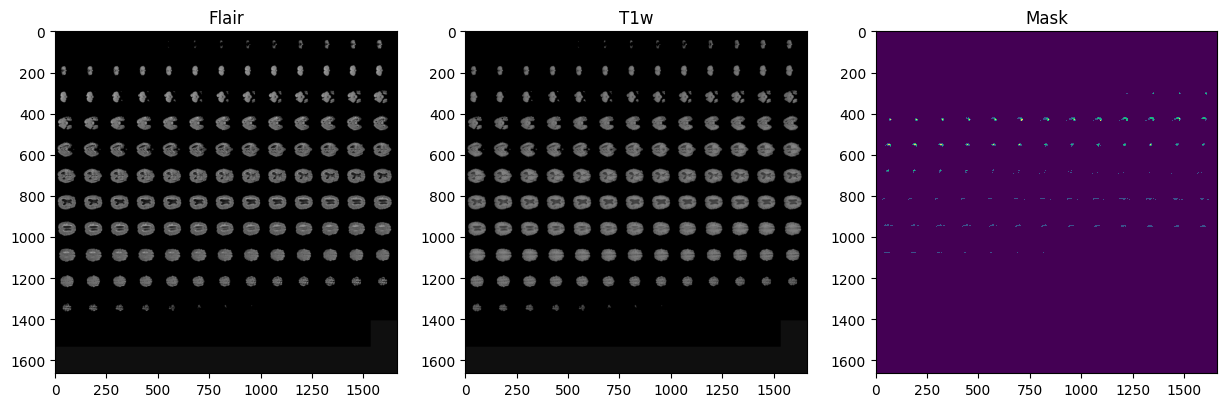

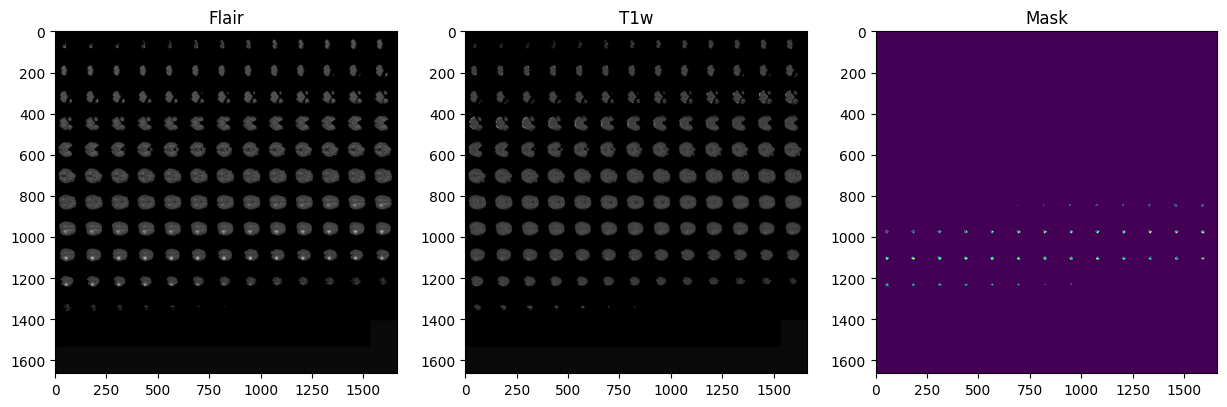

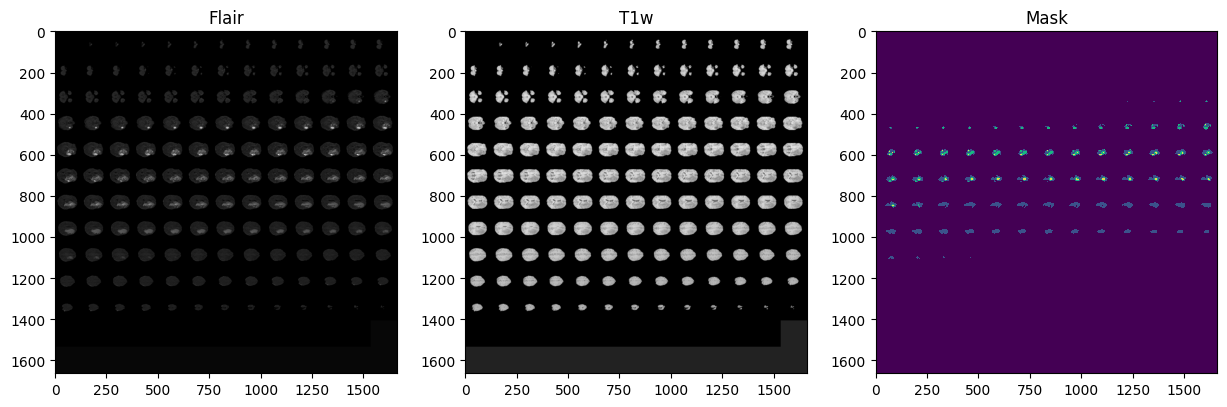

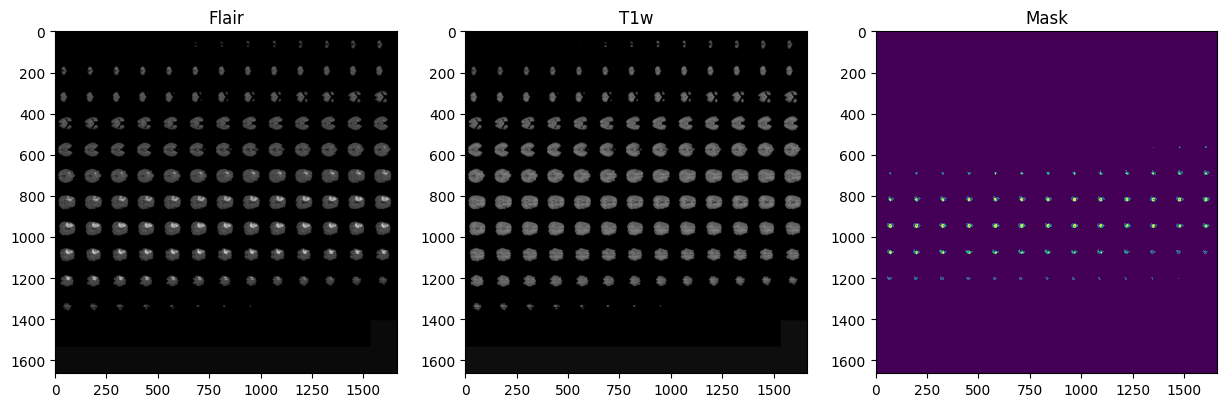

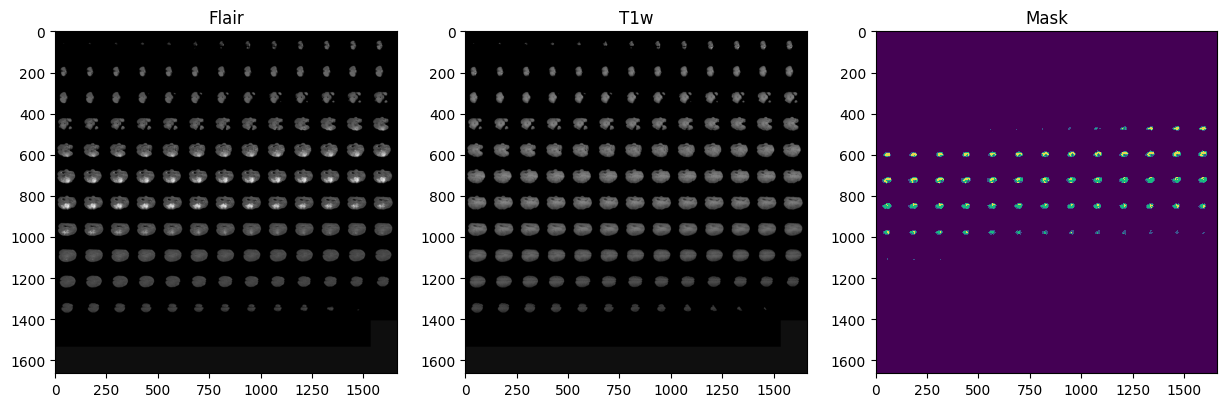

In [29]:
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()

for i, (X, y) in enumerate(train_loader):
    if i >= 5:
        break
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.imshow(
        montage(X[0, :, :, :, 0]),
        cmap="gray",
    )
    plt.title("Flair")

    plt.subplot(1, 3, 2)
    plt.imshow(
        montage(X[0, :, :, :, 1]),
        cmap="gray",
    )
    plt.title("T1w")

    # Mask
    cmap = matplotlib.colors.ListedColormap(
        ["#440054", "#3b528b", "#18b880", "#e6d74f"]
    )
    norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)
    mask = y[0, :, 1, :, :] + 2 * y[0, :, 2, :, :] + 3 * y[0, :, 3, :, :]
    plt.subplot(1, 3, 3)
    plt.imshow(montage(mask[:, :, :]), cmap=cmap, norm=norm)
    plt.title("Mask")

    plt.show()